
# getting used to dynamic programming
## get the U policy matrix of forces for a point mass system with drag

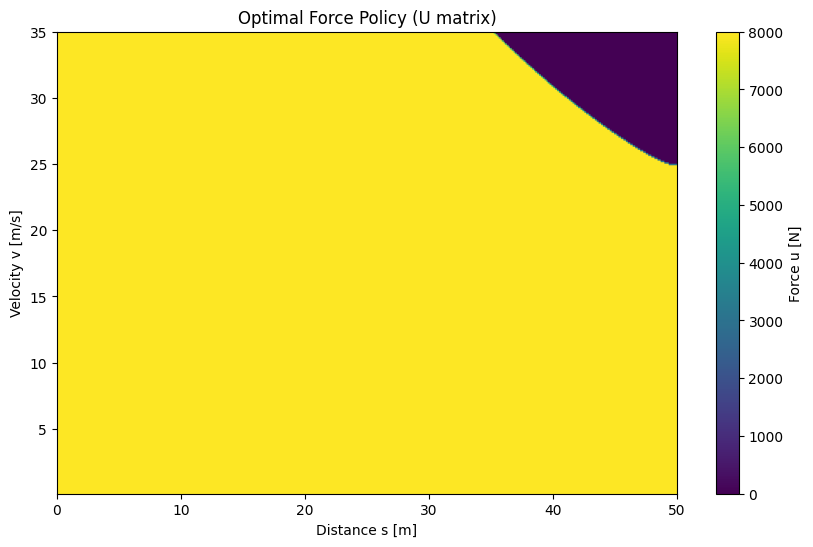

In [269]:

import numpy as np
import matplotlib.pyplot as plt

v_min = 0.1      
v_max = 35
L = 50

u_min = 0.1
u_max = 8000
m = 180     #kg
CdA = 5     #m^2

ds = 0.05     # spatial step [m]
v_T = 25     # target terminal velocity

# Discretization
Ns = int(L/ds) + 1       # distance grid divisions
Nv = 300     # veocity grid divisions
Nu = 40    # force gird divisions

s_grid = np.linspace(0.0, L, Ns)
v_grid = np.linspace(v_min, v_max, Nv)
u_grid = np.linspace(u_min, u_max, Nu)
ds = s_grid[1]-s_grid[0]

# Cost matrix
J = np.full((Nv, Ns), np.inf)

#set the initial cost as sqaured distance form desired terminal velocity
for j, cost in enumerate(J[: , -1]):
    value = (v_grid[j] - v_T) ** 2
    J[j , -1] = value



#optimal force policy
U = np.zeros((Nv, Ns))

for k in range(Ns - 2, -1, -1):
    for j, v in enumerate(v_grid):
        dt = ds / v
        best_cost = np.inf
        best_u = 0

        for u in u_grid:
            v_next = v + (dt/m) * (u - CdA * v**2)

            #interpolation
            v_next = np.clip(v_next, v_grid[0], v_grid[-1])


            hi = np.searchsorted(v_grid, v_next) # finds index where velocity would be inserted
            lo = hi - 1
            w = (v_next - v_grid[lo]) / (v_grid[hi] - v_grid[lo])

            if J[lo, k + 1] == np.inf:
                print("infinity in lo")

            if J[hi, k + 1] == np.inf:
                print("infinity in hi")

            Jn = (1-w) * J[lo, k + 1] + w * J[hi, k + 1]

            total_cost = dt + Jn
            if total_cost < best_cost:
                best_cost = total_cost
                best_u = u

        J[j, k] = best_cost
        U[j, k] = best_u

plt.figure(figsize=(10, 6))
plt.imshow(U, origin='lower', aspect='auto',
           extent=[s_grid[0], s_grid[-1], v_grid[0], v_grid[-1]],
           cmap='viridis')
plt.colorbar(label='Force u [N]')
plt.xlabel('Distance s [m]')
plt.ylabel('Velocity v [m/s]')
plt.title('Optimal Force Policy (U matrix)')
plt.show()


# nevypínat, chroustá to číslíčka


chatgpt generated slop to plot the trajectory stemming from optimal force policy:


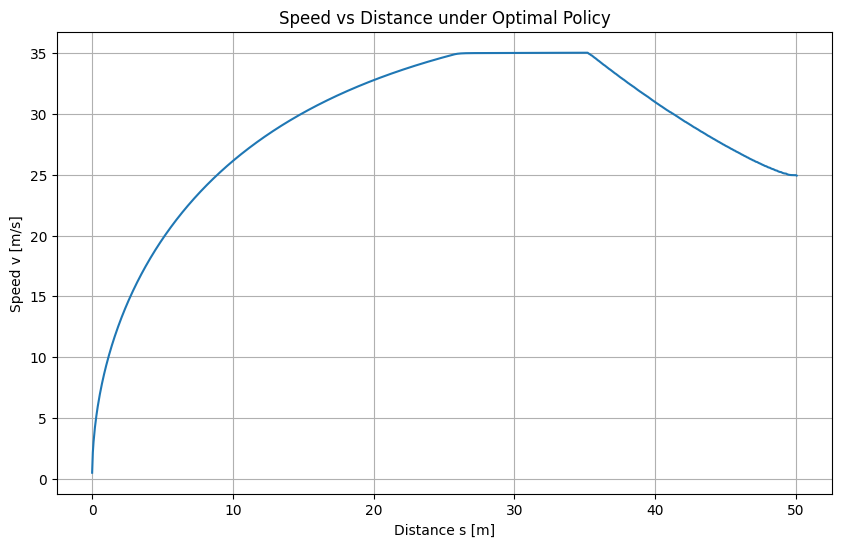

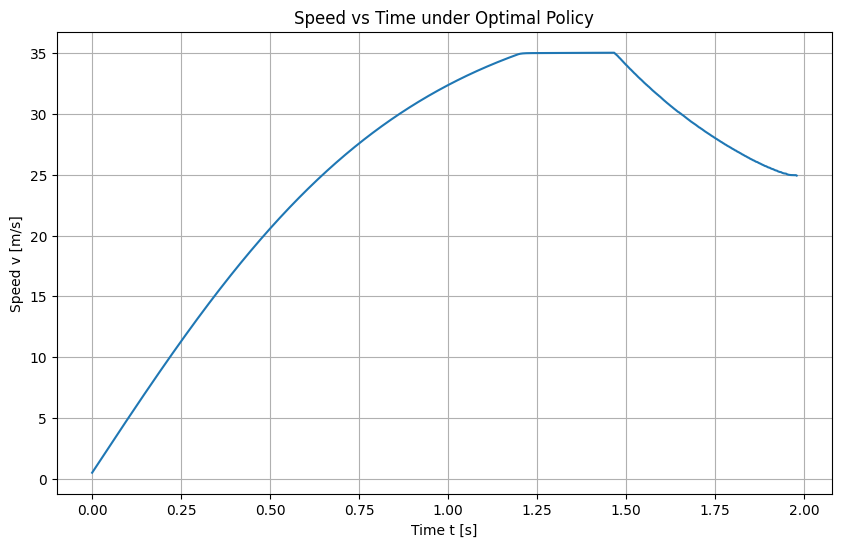

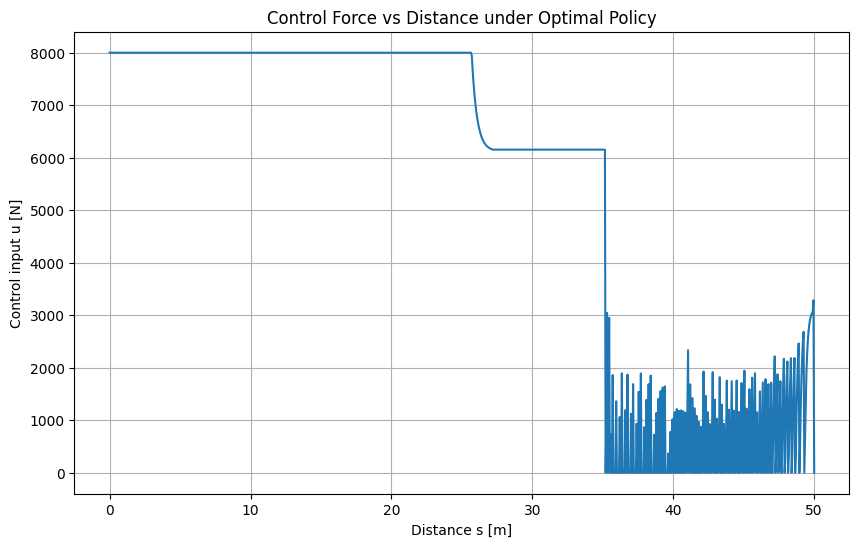

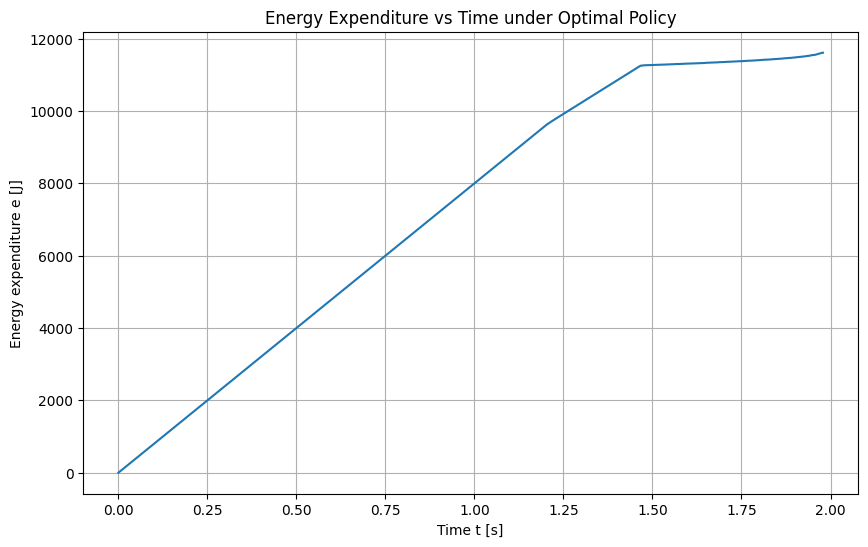

In [270]:
U = U.T
J = J.T

def interp2_policy(U, s, v, s_grid, v_grid):
    s = np.clip(s, s_grid[0], s_grid[-1])
    v = np.clip(v, v_grid[0], v_grid[-1])
    i = np.searchsorted(s_grid, s) - 1
    j = np.searchsorted(v_grid, v) - 1
    i = np.clip(i, 0, len(s_grid) - 2)
    j = np.clip(j, 0, len(v_grid) - 2)
    s0, s1 = s_grid[i], s_grid[i + 1]
    v0, v1 = v_grid[j], v_grid[j + 1]
    ts = 0.0 if s1 == s0 else (s - s0) / (s1 - s0)
    tv = 0.0 if v1 == v0 else (v - v0) / (v1 - v0)
    Q11, Q21 = U[i, j], U[i + 1, j]
    Q12, Q22 = U[i, j + 1], U[i + 1, j + 1]
    return (1 - ts) * (1 - tv) * Q11 + ts * (1 - tv) * Q21 + (1 - ts) * tv * Q12 + ts * tv * Q22


# --- simulation ---
s0, v0 = 0.0, 0.5
ds_sim = 0.05
s_hist, v_hist, t_hist, u_hist, e_hist = [s0], [v0], [0.0], [], [0.0]
s, v, t, e = s0, v0, 0.0, 0.0

for _ in range(int(np.ceil((L - s0) / ds_sim)) + 5000):
    if s >= L:
        break

    u = float(interp2_policy(U, s, v, s_grid, v_grid))
    v_sq_next = v**2 + (2.0 / m) * (u - CdA * v**2) * ds_sim
    if v_sq_next <= 0:
        v_next = 0.0
        s_hist.append(s)
        v_hist.append(v_next)
        t_hist.append(t)
        u_hist.append(u)
        e_hist.append(e)
        break

    v_next = np.sqrt(v_sq_next)
    v_avg = max(1e-6, 0.5 * (v + v_next))
    dt = ds_sim / v_avg

    # integrate energy expenditure
    e += u * dt

    t += dt
    s += ds_sim
    s_hist.append(s)
    v_hist.append(v_next)
    t_hist.append(t)
    u_hist.append(u)
    e_hist.append(e)
    v = v_next

# --- plots ---
plt.figure(figsize=(10, 6))
plt.plot(s_hist, v_hist)
plt.xlabel("Distance s [m]")
plt.ylabel("Speed v [m/s]")
plt.title("Speed vs Distance under Optimal Policy")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(t_hist, v_hist)
plt.xlabel("Time t [s]")
plt.ylabel("Speed v [m/s]")
plt.title("Speed vs Time under Optimal Policy")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(s_hist[:-1], u_hist)
plt.xlabel("Distance s [m]")
plt.ylabel("Control input u [N]")
plt.title("Control Force vs Distance under Optimal Policy")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(t_hist, e_hist)
plt.xlabel("Time t [s]")
plt.ylabel("Energy expenditure e [J]")
plt.title("Energy Expenditure vs Time under Optimal Policy")
plt.grid(True)
plt.show()


## adding third state to track control expenditure setpoint


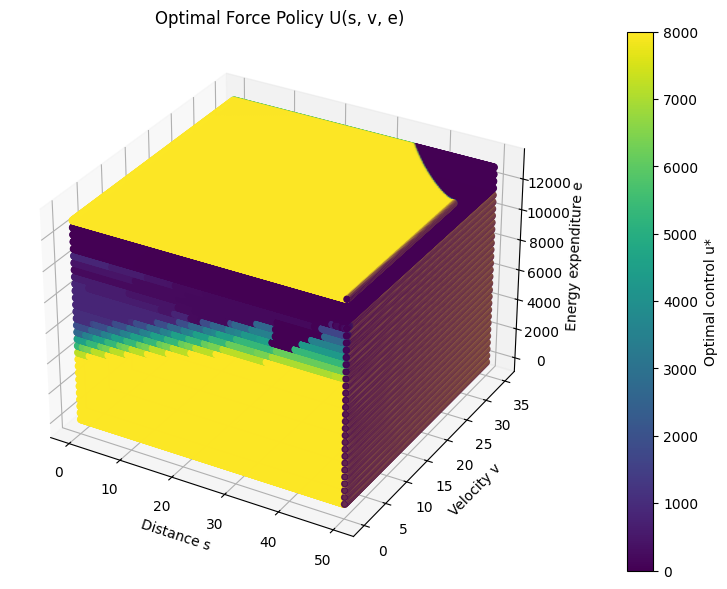

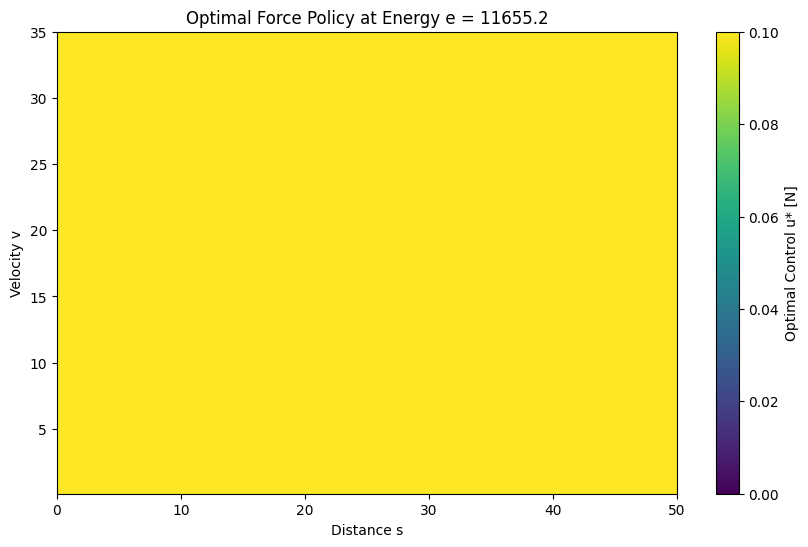

In [271]:
Ne = 30
e_max = 13000
e_min = 0.1
e_T = 11500


s_grid = np.linspace(0.0, L, Ns)
v_grid = np.linspace(v_min, v_max, Nv)
u_grid = np.linspace(u_min, u_max, Nu)
e_grid = np.linspace(e_min, e_max, Ne)

# Cost tensor
J = np.full((Nv, Ns, Ne), np.inf)

#set the initial cost as sqaured distance form desired terminal velocity + squared deviation from desired control expenditure
for v in range(J.shape[0]):
    for e in range(J.shape[2]):
        cost = (v_grid[v] - v_T) ** 2 + (e_grid[e] - e_T) ** 2
        J[v, -1, e] = cost



#optimal force policy
U = np.zeros((Nv, Ns, Ne))

for k in range(Ns - 2, -1, -1):
    for j, v in enumerate(v_grid):
        dt = ds / v
        for ei, e in enumerate(e_grid):
            best_cost = np.inf
            best_u = -2000

            for u in u_grid:
                # Dynamics update
                v_next = v + (dt / m) * (u - CdA * v**2)
                e_next = e + u * dt  # integrate control effort

                # Skip invalid velocity or energy states
                v_next = np.clip(v_next, v_grid[0], v_grid[-1])
                e_next = np.clip(e_next, e_grid[0], e_grid[-1])


                # --- Interpolation in v ---
                hi_v = np.searchsorted(v_grid, v_next)
                lo_v = hi_v - 1
                wv = (v_next - v_grid[lo_v]) / (v_grid[hi_v] - v_grid[lo_v])

                # --- Interpolation in e ---
                hi_e = np.searchsorted(e_grid, e_next)
                lo_e = hi_e - 1
                we = (e_next - e_grid[lo_e]) / (e_grid[hi_e] - e_grid[lo_e])

                # Bilinear interpolation of next-step cost Jn
                J_lo = (1 - we) * J[lo_v, k + 1, lo_e] + we * J[lo_v, k + 1, hi_e]
                J_hi = (1 - we) * J[hi_v, k + 1, lo_e] + we * J[hi_v, k + 1, hi_e]
                Jn = (1 - wv) * J_lo + wv * J_hi

                total_cost = dt + Jn

                if total_cost < best_cost:
                    best_cost = total_cost
                    best_u = u

            J[j, k, ei] = best_cost
            U[j, k, ei] = best_u

S, V, E = np.meshgrid(s_grid, v_grid, e_grid, indexing='ij')

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Flatten for scatter plotting
sc = ax.scatter(
    S.flatten(), 
    V.flatten(), 
    E.flatten(), 
    c=U.transpose(1,0,2).flatten(),  # match mesh indexing
    cmap='viridis', 
    s=20
)

ax.set_xlabel('Distance s')
ax.set_ylabel('Velocity v')
ax.set_zlabel('Energy expenditure e')
cb = plt.colorbar(sc, ax=ax, pad=0.1)
cb.set_label('Optimal control u*')

plt.title('Optimal Force Policy U(s, v, e)')
plt.show()

# --- 2D slice at e_T (energy expenditure target) ---
e_index = np.argmin(np.abs(e_grid - e_T))
e_value = e_grid[e_index]

# Extract slice U(s, v, e_T)
U_slice = U[:, :, e_index].T  # shape (Nv, Ns)

plt.figure(figsize=(10, 6))
plt.imshow(
    U_slice,
    origin='lower',
    aspect='auto',
    cmap='viridis',
    extent=[s_grid[0], s_grid[-1], v_grid[0], v_grid[-1]]
)
plt.xlabel("Distance s")
plt.ylabel("Velocity v")
plt.title(f"Optimal Force Policy at Energy e = {e_value:.1f}")
cbar = plt.colorbar()
cbar.set_label("Optimal Control u* [N]")
plt.show() #fix this shit, doesnt work



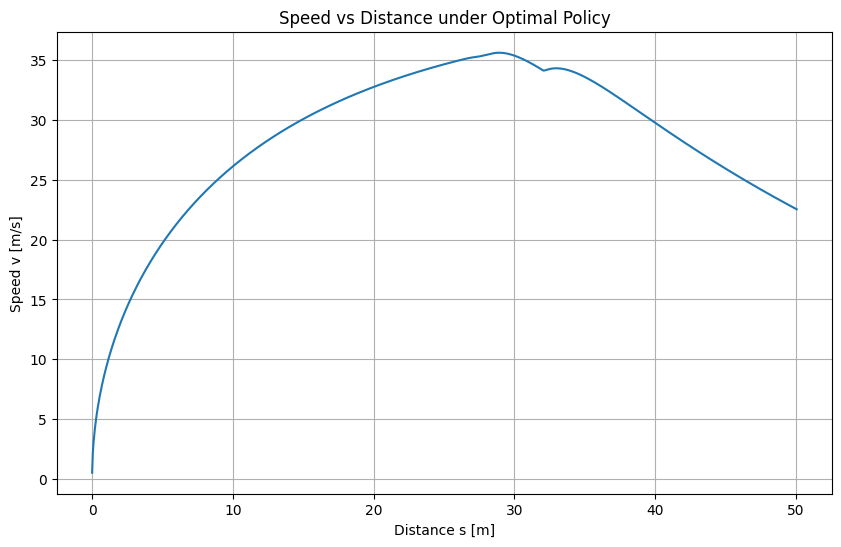

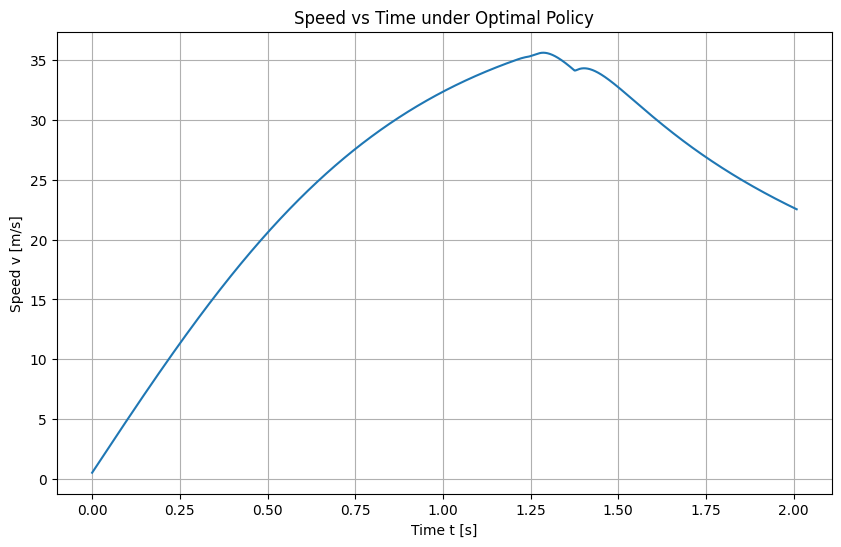

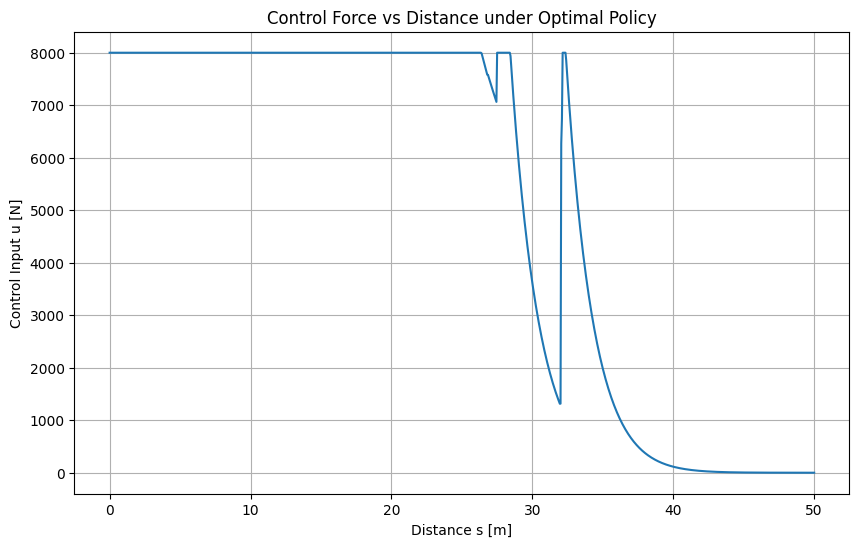

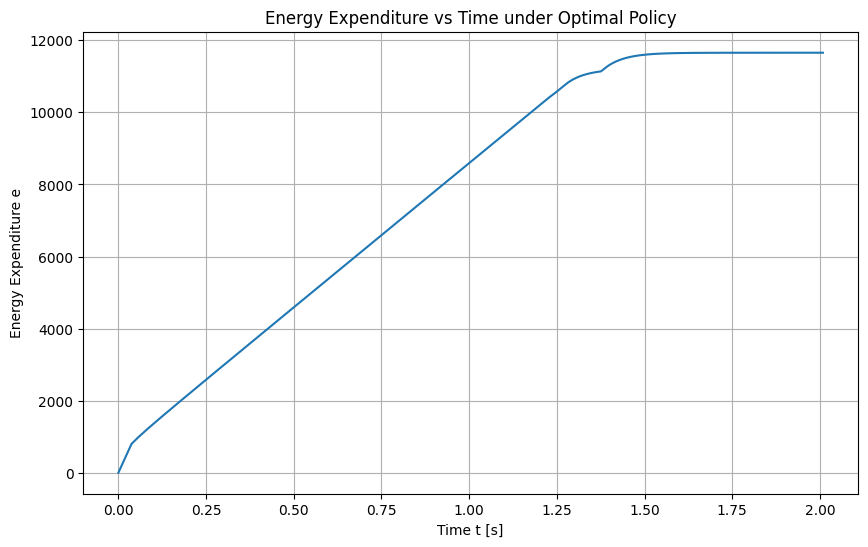

In [272]:
U = U.transpose(1, 0, 2)  # shape (Ns, Nv, Ne)
J = J.transpose(1, 0, 2)

def interp3_policy(U, s, v, e, s_grid, v_grid, e_grid):
    # Clip to domain
    s = np.clip(s, s_grid[0], s_grid[-1])
    v = np.clip(v, v_grid[0], v_grid[-1])
    e = np.clip(e, e_grid[0], e_grid[-1])

    # Index bracketing
    i = np.searchsorted(s_grid, s) - 1
    j = np.searchsorted(v_grid, v) - 1
    k = np.searchsorted(e_grid, e) - 1
    i = np.clip(i, 0, len(s_grid) - 2)
    j = np.clip(j, 0, len(v_grid) - 2)
    k = np.clip(k, 0, len(e_grid) - 2)

    # Grid points
    s0, s1 = s_grid[i], s_grid[i + 1]
    v0, v1 = v_grid[j], v_grid[j + 1]
    e0, e1 = e_grid[k], e_grid[k + 1]

    # Normalized interpolation weights
    ts = 0.0 if s1 == s0 else (s - s0) / (s1 - s0)
    tv = 0.0 if v1 == v0 else (v - v0) / (v1 - v0)
    te = 0.0 if e1 == e0 else (e - e0) / (e1 - e0)

    # Trilinear interpolation of control field
    def U_at(ii, jj, kk): return U[ii, jj, kk]
    result = (
        (1 - ts) * (1 - tv) * (1 - te) * U_at(i, j, k)
        + ts * (1 - tv) * (1 - te) * U_at(i + 1, j, k)
        + (1 - ts) * tv * (1 - te) * U_at(i, j + 1, k)
        + ts * tv * (1 - te) * U_at(i + 1, j + 1, k)
        + (1 - ts) * (1 - tv) * te * U_at(i, j, k + 1)
        + ts * (1 - tv) * te * U_at(i + 1, j, k + 1)
        + (1 - ts) * tv * te * U_at(i, j + 1, k + 1)
        + ts * tv * te * U_at(i + 1, j + 1, k + 1)
    )
    return result


# --- simulate trajectory following optimal policy ---
s0, v0, e0 = 0.0, 0.5, 0.0
ds_sim = 0.05
s, v, e, t = s0, v0, e0, 0.0

s_hist, v_hist, e_hist, t_hist, u_hist = [s], [v], [e], [0.0], []

for _ in range(int(np.ceil((L - s0) / ds_sim)) + 5000):
    if s >= L:
        break

    u = float(interp3_policy(U, s, v, e, s_grid, v_grid, e_grid))
    v_sq_next = v ** 2 + (2.0 / m) * (u - CdA * v ** 2) * ds_sim
    if v_sq_next <= 0:
        v_next = 0.0
        s_hist.append(s)
        v_hist.append(v_next)
        e_hist.append(e)
        t_hist.append(t)
        u_hist.append(u)
        break

    v_next = np.sqrt(v_sq_next)
    e_next = e + u * (ds_sim / v)  # energy integration
    v_avg = max(1e-6, 0.5 * (v + v_next))
    t += ds_sim / v_avg
    s += ds_sim

    s_hist.append(s)
    v_hist.append(v_next)
    e_hist.append(e_next)
    t_hist.append(t)
    u_hist.append(u)

    v, e = v_next, e_next

# --- plot results ---
plt.figure(figsize=(10, 6))
plt.plot(s_hist, v_hist)
plt.xlabel("Distance s [m]")
plt.ylabel("Speed v [m/s]")
plt.title("Speed vs Distance under Optimal Policy")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(t_hist, v_hist)
plt.xlabel("Time t [s]")
plt.ylabel("Speed v [m/s]")
plt.title("Speed vs Time under Optimal Policy")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(s_hist[:-1], u_hist)
plt.xlabel("Distance s [m]")
plt.ylabel("Control Input u [N]")
plt.title("Control Force vs Distance under Optimal Policy")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(t_hist, e_hist)
plt.xlabel("Time t [s]")
plt.ylabel("Energy Expenditure e")
plt.title("Energy Expenditure vs Time under Optimal Policy")
plt.grid(True)
plt.show()
